In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')
rc('axes', axisbelow=True)

### Problem 2(a)

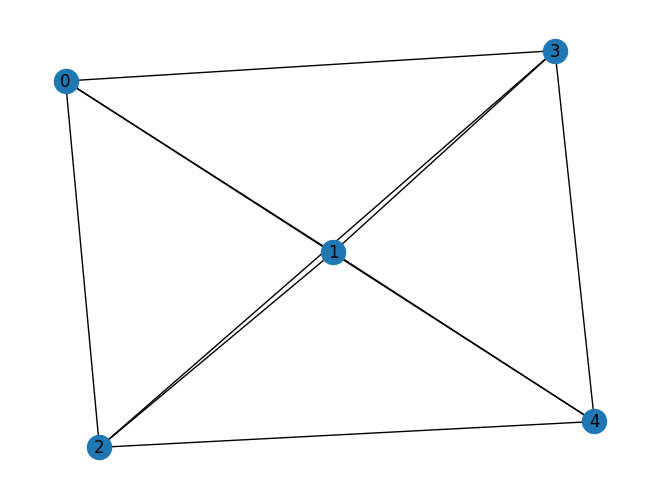

In [2]:
n = 5
G = nx.complete_graph(n)

nx.draw(G, with_labels = True)

plt.savefig('/Users/lpwer/Documents/NetSIPhD/PHYS7332_NetData/HW1/problem2a.png', bbox_inches='tight')

### Problem 2b

In [3]:
def degree_preserving_randomization(G, n_iter = 500, fail_max = 200):
    """
    Perform degree-preserving randomization on a graph. 

    This function is modified based on Algorithm 11.1 in Bagrow & Ahn textbook. This version of randomization prevent an infinite loop
    by abandoning the exvhange process after reaching a given number of attempts without a successful exchange. 
    
    Parameters
    ----------
    G : networkx.Graph
        the input graph to be randomized. The graph can be directed or undirected. Must be simple. 

    n_iter : int, optional (default = 1000)
        the number of edge exchange to perform. A higher number of iteration leads to more randomization. 
        In this case, we preserve the degree of nodes. This number should be proportional to the number of edges in the graph
        for sufficient randomization. 

    fail_max : int 
        fail_max is a counter cap that makes sure the exchange process will stop if the infinite loop happens. 

    Returns
    -------
    G_random : networkx.Graph
        A randomized graph with same degree distirbution as the input graph G but with a shuffled edge structure. 

    Notes
    -----
    - This function works by randomly select two independent edges in the network (u, v) and (x, y).
      The attempted exchanges are {(u, x), (v, y)} and {(u, y), (x, v)}.
    - swapped is a flag that checks on whether the edge exchange is successful or not. 
      If swapped is true, then add 1 to the success counter and reset the n_fail counter. 
    - When number of failure reaches the max failure, raise the runtime error and stop the function. 

    Example
    -------
    >>> import networkx as nx
    >>> G = nx.erdos_renyi_graph(10, 0.5)
    >>> G_random = degree_preserving_randomization(G, n_iter=100)

    Citations
    ---------
    Klein, Brennan. PHYS 7332 Fall 2025 Class04 notes
    """
    G_random = G.copy()
    edges = list(G_random.edges())
    num_edge = len(edges)
    n_fail = 0
    success = 0 

    swapped = False

    while n_fail < fail_max and success < n_iter:
        edge1_id = np.random.choice(list(range(num_edge)))
        u, v = edges[edge1_id]
        edge2_id = np.random.choice(list(range(num_edge)))
        x, y = edges[edge2_id]
        
        if len({u, v, x, y}) == 4 and n_fail < fail_max:
            if np.random.rand() > 0.5:
                if not (G_random.has_edge(u, x) or G_random.has_edge(v, y)):
                    G_random.remove_edge(u,v)
                    G_random.remove_edge(x,y)
                    G_random.add_edge(u,x)
                    G_random.add_edge(v,y)
                    swapped = True
                        
            else:
                if not (G_random.has_edge(u, y) or G_random.has_edge(v, x)):
                    G_random.remove_edge(u,v)
                    G_random.remove_edge(x,y)
                    G_random.add_edge(u,y)
                    G_random.add_edge(v,x)
                    swapped = True
        if swapped:
            success += 1
            n_fail = 0
            edges = list(G_random.edges())
        else:
            n_fail += 1

    if n_fail >= fail_max:
        raise RuntimeError(f"Stopped: reached {fail_max} consecutive failed attempts. "
                       "No further swaps possible.")
            
    return G_random

Text(0.5, 1.0, 'Randomized graph')

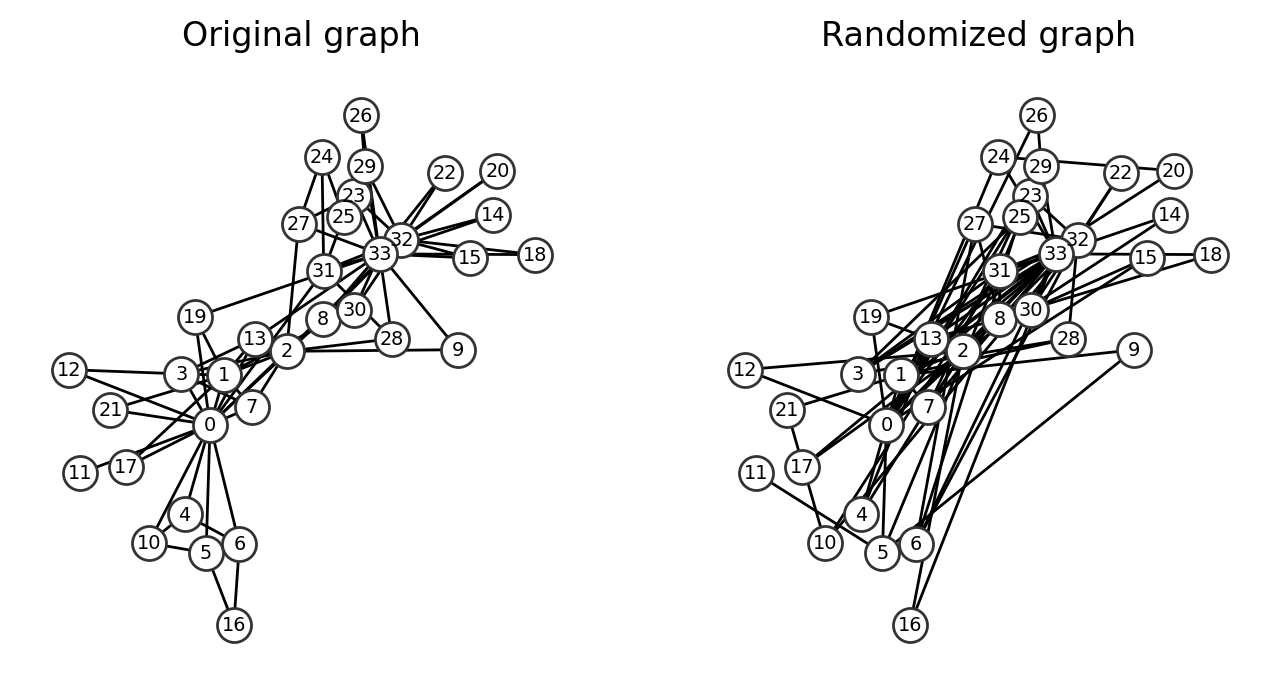

In [4]:
G = nx.karate_club_graph()
# G = nx.complete_graph(30)
G_random = degree_preserving_randomization(G)
# plot
pos = nx.spring_layout(G)
fig, ax = plt.subplots(1, 2, figsize=(8,4), dpi=200)

nx.draw(G, pos, node_size = 150, node_color='w', edgecolors='.2',
        with_labels=True, font_size='x-small', ax = ax[0])
ax[0].set_title('Original graph')

nx.draw(G_random, pos, node_size = 150, node_color='w', edgecolors='.2',
        with_labels=True, font_size='x-small', ax = ax[1])
ax[1].set_title('Randomized graph')


### P2 (c)

In [67]:
import numpy as np
import networkx as nx

def degree_preserving_randomization(
    G,
    n_iter=500,
    fail_max=200,
    connectivity='auto',        # 'auto' | 'undirected' | 'weak' | 'strong' | None
    preserve_partition=False,    # if True, preserve exact component membership (costlier)
    seed=None
):
    """
    Degree-preserving edge-swap randomization with optional connectivity preservation.

    Parameters
    ----------
    G : nx.Graph or nx.DiGraph
        Simple graph (no multiedges), directed or undirected.

    n_iter : int
        Target number of successful swaps.

    fail_max : int
        Max consecutive failed attempts before aborting.

    connectivity : {'auto','undirected','weak','strong', None}
        If 'undirected': preserve connectivity (nx.is_connected) for Graph.
        If 'weak':       preserve weak connectivity (one weak component) for DiGraph.
        If 'strong':     preserve strong connectivity (one strongly-connected component).
        If 'auto':       'undirected' for Graph, 'weak' for DiGraph.
        If None:         do not enforce connectivity (classic double-edge swap).

    preserve_partition : bool
        If True, preserve the exact component partition of the original graph
        (same nodes stay in same component labels). This is stricter and slower.
        For most null models, preserving connectedness (single component) is enough.

    seed : int or None
        RNG seed for reproducibility.

    Returns
    -------
    G_random : nx.Graph or nx.DiGraph
        Degree-preserving randomized graph that respects the chosen connectivity constraint.

    Notes
    -----
    - Uses two-edge swaps on pairs of independent edges (u->v) and (x->y):
        option A: (u->y) and (x->v)
        option B: (u->x) and (v->y)     (for DiGraph, directions matter)
    - Rejects swaps that would introduce parallel edges or self-loops.
    - With connectivity constraints, many swaps get rejected; consider raising n_iter
      and/or fail_max, or run multiple passes.

    Raises
    ------
    RuntimeError if fail_max consecutive attempts fail.
    """
    rng = np.random.default_rng(seed)
    G_random = G.copy()
    is_directed = G_random.is_directed()

    # Resolve connectivity mode
    if connectivity == 'auto':
        connectivity = 'weak' if is_directed else 'undirected'

    # Capture the original connectivity “baseline”
    if connectivity is None:
        baseline = None
    else:
        if not is_directed and connectivity != 'undirected':
            raise ValueError("Undirected graphs must use connectivity='undirected' or None.")
        if is_directed and connectivity == 'undirected':
            raise ValueError("Use 'weak' or 'strong' for directed graphs, or None.")

        if not is_directed:  # Graph
            baseline = {
                'connected': nx.is_connected(G_random),
            }
            if preserve_partition:
                comp_map = {}
                for cid, comp in enumerate(nx.connected_components(G_random)):
                    for n in comp:
                        comp_map[n] = cid
                baseline['comp_map'] = comp_map

        else:  # DiGraph
            if connectivity == 'weak':
                comps = list(nx.weakly_connected_components(G_random))
                baseline = {'n_comps': len(comps)}
                if preserve_partition:
                    comp_map = {}
                    for cid, comp in enumerate(comps):
                        for n in comp:
                            comp_map[n] = cid
                    baseline['comp_map'] = comp_map
            elif connectivity == 'strong':
                comps = list(nx.strongly_connected_components(G_random))
                baseline = {'n_comps': len(comps)}
                if preserve_partition:
                    comp_map = {}
                    for cid, comp in enumerate(comps):
                        for n in comp:
                            comp_map[n] = cid
                    baseline['comp_map'] = comp_map
            else:
                raise ValueError("connectivity must be 'weak', 'strong', 'undirected', 'auto', or None.")

    def connectivity_ok(H):
        """Check connectivity constraint relative to baseline."""
        if connectivity is None:
            return True

        if not is_directed:
            if baseline['connected']:
                if not nx.is_connected(H):
                    return False
                if preserve_partition:
                    # Re-label current components and compare node->component map
                    curr_map = {}
                    for cid, comp in enumerate(nx.connected_components(H)):
                        for n in comp:
                            curr_map[n] = cid
                    # Components are unlabeled; compare partition sets by signature:
                    # build {node: orig_label} and {node: new_label}, then ensure
                    # for all u,v, (orig[u]==orig[v]) iff (curr[u]==curr[v]).
                    # Faster: compare frozenset of frozensets:
                    def part_signature(map_):
                        inv = {}
                        for n,lbl in map_.items():
                            inv.setdefault(lbl,set()).add(n)
                        return frozenset(frozenset(s) for s in inv.values())
                    return part_signature(baseline['comp_map']) == part_signature(curr_map)
                return True
            else:
                # Multi-component case: preserve partition or at least component count
                curr = list(nx.connected_components(H))
                if preserve_partition:
                    curr_map = {}
                    for cid, comp in enumerate(curr):
                        for n in comp:
                            curr_map[n] = cid
                    def part_signature(map_):
                        inv = {}
                        for n,lbl in map_.items():
                            inv.setdefault(lbl,set()).add(n)
                        return frozenset(frozenset(s) for s in inv.values())
                    return part_signature(baseline['comp_map']) == part_signature(curr_map)
                else:
                    return len(curr) == len(list(nx.connected_components(G_random)))

        else:
            if connectivity == 'weak':
                curr = list(nx.weakly_connected_components(H))
            else:
                curr = list(nx.strongly_connected_components(H))

            if preserve_partition:
                curr_map = {}
                for cid, comp in enumerate(curr):
                    for n in comp:
                        curr_map[n] = cid
                def part_signature(map_):
                    inv = {}
                    for n,lbl in map_.items():
                        inv.setdefault(lbl,set()).add(n)
                    return frozenset(frozenset(s) for s in inv.values())
                return part_signature(baseline['comp_map']) == part_signature(curr_map)
            else:
                return len(curr) == baseline['n_comps']

    # Main swap loop
    edges = list(G_random.edges())
    m = len(edges)
    if m < 2:
        return G_random

    n_fail = 0
    success = 0

    while n_fail < fail_max and success < n_iter:
        swapped = False  # reset each attempt

        # Sample two distinct edges uniformly at random
        e1_idx = rng.integers(0, m)
        e2_idx = rng.integers(0, m - 1)
        if e2_idx >= e1_idx:
            e2_idx += 1
        (u, v) = edges[e1_idx]
        (x, y) = edges[e2_idx]

        # Require four distinct nodes (avoids self-loops)
        if len({u, v, x, y}) != 4:
            n_fail += 1
            continue

        # Two possible rewires:
        # Option A: (u, v) + (x, y) -> (u, y) + (x, v)
        # Option B: (u, v) + (x, y) -> (u, x) + (v, y)
        # For undirected graphs, directions are ignored by NetworkX API.
        candidates = []
        if not (G_random.has_edge(u, y) or G_random.has_edge(x, v)):
            candidates.append(((u, v), (x, y), (u, y), (x, v)))
        if not (G_random.has_edge(u, x) or G_random.has_edge(v, y)):
            candidates.append(((u, v), (x, y), (u, x), (v, y)))

        if not candidates:
            n_fail += 1
            continue

        # Randomly choose one candidate rewire
        (e1_old, e2_old, e1_new, e2_new) = candidates[rng.integers(0, len(candidates))]

        # Try the swap
        G_random.remove_edge(*e1_old)
        G_random.remove_edge(*e2_old)
        G_random.add_edge(*e1_new)
        G_random.add_edge(*e2_new)

        if connectivity_ok(G_random):
            swapped = True
        else:
            # Revert the swap
            G_random.remove_edge(*e1_new)
            G_random.remove_edge(*e2_new)
            G_random.add_edge(*e1_old)
            G_random.add_edge(*e2_old)
            swapped = False

        if swapped:
            success += 1
            n_fail = 0
            edges = list(G_random.edges())
            m = len(edges)
        else:
            n_fail += 1

    if n_fail >= fail_max:
        raise RuntimeError(
            f"Stopped: reached {fail_max} consecutive failed attempts. "
            "No further swaps possible under the connectivity constraint."
        )

    return G_random


Text(0.5, 1.0, 'Randomized graph')

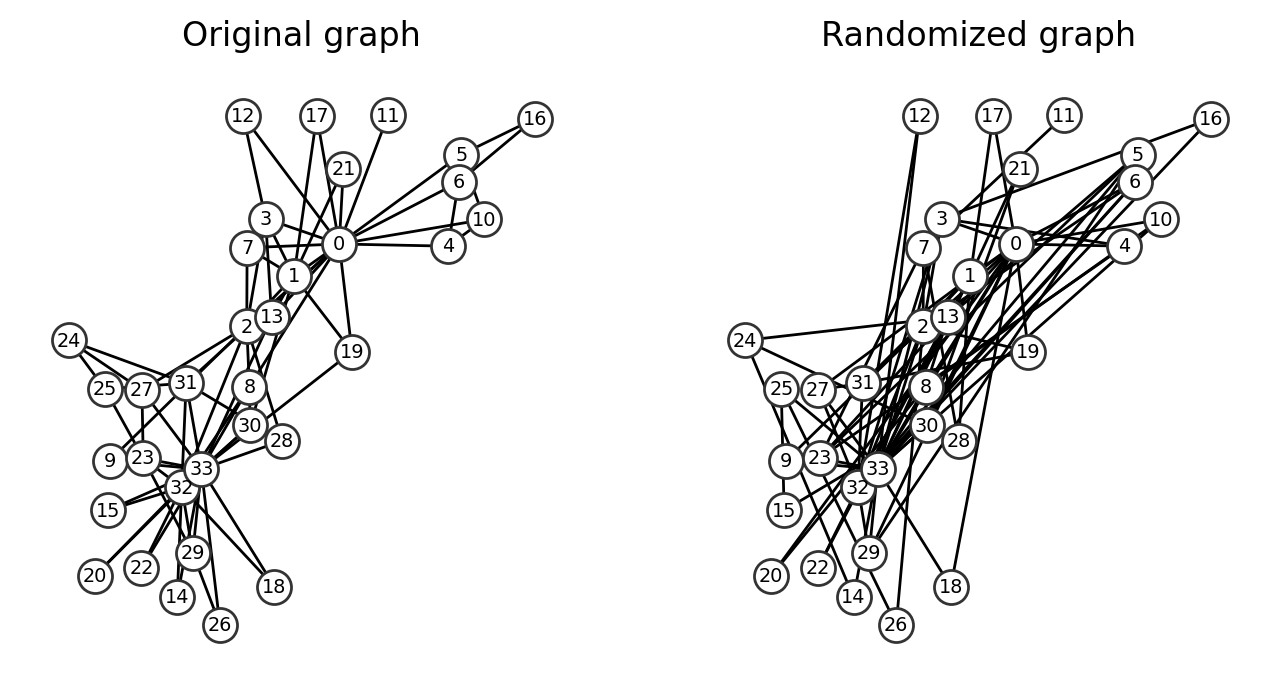

In [68]:
G = nx.karate_club_graph()
# G = nx.complete_graph(30)
G_random = degree_preserving_randomization(G)
# plot
pos = nx.spring_layout(G)
fig, ax = plt.subplots(1, 2, figsize=(8,4), dpi=200)

nx.draw(G, pos, node_size = 150, node_color='w', edgecolors='.2',
        with_labels=True, font_size='x-small', ax = ax[0])
ax[0].set_title('Original graph')

nx.draw(G_random, pos, node_size = 150, node_color='w', edgecolors='.2',
        with_labels=True, font_size='x-small', ax = ax[1])
ax[1].set_title('Randomized graph')


### P2 (d)

In [1]:
import numpy as np
import networkx as nx
from collections import Counter

def degree_preserving_randomization_preserve_xcorr(
    G,
    x_attr="x",            # node attribute name OR a dict {node: -1 or 1}
    n_iter=500,
    fail_max=200,
    seed=None,
    ordered=None           # if None: directed -> ordered, undirected -> unordered
):
    """
    Degree-preserving edge-swap randomization that ALSO preserves the
    correlation on edges of a binary node attribute x ∈ {-1, 1}.
    
    Constraint: For any two edges (u,v) and (x,y) chosen for rewiring,
    the multiset of edge types {(x_u, x_v), (x_x, x_y)} must be conserved
    after rewiring. For directed graphs, types are ordered pairs; for
    undirected graphs, types are unordered pairs.

    Parameters
    ----------
    G : nx.Graph or nx.DiGraph
    x_attr : str or dict
        If str, read node attribute G.nodes[n][x_attr] ∈ {-1,1}.
        If dict, mapping {node: -1 or 1}.
    n_iter : int
        Target number of successful swaps.
    fail_max : int
        Abort after this many consecutive failed attempts.
    seed : int or None
        RNG seed.
    ordered : bool or None
        Treat edge types as ordered pairs (True) or unordered pairs (False).
        Default: directed -> True; undirected -> False.

    Returns
    -------
    G_random : same type as G
    """
    rng = np.random.default_rng(seed)
    H = G.copy()
    is_dir = H.is_directed()
    if ordered is None:
        ordered = is_dir

    # Build x map
    if isinstance(x_attr, dict):
        x = x_attr
    else:
        x = {n: H.nodes[n][x_attr] for n in H.nodes()}
    # Validate binary {-1,1}
    for n, val in x.items():
        if val not in (-1, 1):
            raise ValueError(f"Node {n} has x={val}; expected -1 or 1.")

    def etype(a, b):
        """Edge type given node attributes."""
        xa, xb = x[a], x[b]
        if ordered:
            return (xa, xb)
        else:
            # unordered pair for undirected graphs
            return tuple(sorted((xa, xb)))

    def same_type_multiset(types_old, types_new):
        """Conserve multiset of two edge types."""
        return Counter(types_old) == Counter(types_new)

    edges = list(H.edges())
    m = len(edges)
    if m < 2:
        return H

    n_fail = 0
    success = 0

    while n_fail < fail_max and success < n_iter:
        swapped = False

        # sample two distinct edges
        i = rng.integers(0, m)
        j = rng.integers(0, m - 1)
        if j >= i: j += 1
        (u, v) = edges[i]
        (a, b) = edges[j]

        # four distinct nodes to avoid self-loops
        if len({u, v, a, b}) != 4:
            n_fail += 1
            continue

        # old types
        T1 = etype(u, v)
        T2 = etype(a, b)

        # candidate rewires (standard two-edge swap)
        cand = []
        # Option A: (u,b) and (a,v)
        if not (H.has_edge(u, b) or H.has_edge(a, v)):
            T1n, T2n = etype(u, b), etype(a, v)
            if same_type_multiset([T1, T2], [T1n, T2n]):
                cand.append(((u, v), (a, b), (u, b), (a, v)))
        # Option B: (u,a) and (v,b)
        if not (H.has_edge(u, a) or H.has_edge(v, b)):
            T1n, T2n = etype(u, a), etype(v, b)
            if same_type_multiset([T1, T2], [T1n, T2n]):
                cand.append(((u, v), (a, b), (u, a), (v, b)))

        if not cand:
            n_fail += 1
            continue

        # try one candidate
        (e1_old, e2_old, e1_new, e2_new) = cand[rng.integers(0, len(cand))]
        H.remove_edge(*e1_old)
        H.remove_edge(*e2_old)
        H.add_edge(*e1_new)
        H.add_edge(*e2_new)

        swapped = True  # type, degree, and simplicity constraints already checked

        if swapped:
            success += 1
            n_fail = 0
            edges = list(H.edges())
            m = len(edges)
        else:
            n_fail += 1

    if n_fail >= fail_max:
        raise RuntimeError(
            f"Stopped after {fail_max} consecutive failed attempts; "
            "type-preserving swaps too constrained."
        )

    return H


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### Problem 3


In [5]:
from collections import deque

def all_shortest_from(G, s):
    """
    Unweighted BFS from source s.
    Returns:
      dist[v]  : shortest-path distance from s to v (=-1 if unreachable)
      g[v]     : number of shortest paths from s to v
      P[v]     : list of predecessors of v on shortest s->v paths
    """
    dist  = {v: -1 for v in G.nodes()}
    g = {v:  0 for v in G.nodes()}
    P = {v: [] for v in G.nodes()}

    dist[s] = 0
    g[s] = 1

    Q = deque([s])
    while Q:
        v = Q.popleft()
        for w in G.neighbors(v):
            if dist[w] < 0:
                dist[w] = dist[v] + 1
                Q.append(w)
            if dist[w] == dist[v] + 1:
                g[w] += g[v]
                P[w].append(v)
    return dist, g, P


def indicator_betweenness_unscaled(G, endpoints=False):
    """
    Indicator betweenness (UNWEIGHTED, UNSCALED):
      For each ordered pair (s, t), s!=t, every node i on at least one
      shortest s->t path gets + 1 / g_st (once per pair).

    endpoints=False: do NOT credit s or t.
    endpoints=True : DO credit s and t as well.
    """
    bc = {v: 0.0 for v in G.nodes()}
    nodes = list(G.nodes())

    for s in nodes:
        dist, g, P = all_shortest_from(G, s)

        # Consider only reachable targets t != s with g[t] > 0
        targets = [t for t in nodes if t != s and g[t] > 0]

        for t in targets:
            contrib = 1.0 / g[t]

            # Reverse-walk the predecessor DAG from t to mark
            # all nodes on at least one shortest s->t path.
            stack = [t]
            visited = {t}
            while stack:
                w = stack.pop()

                # Credit rule: indicator version (once per (s,t) if w lies on any shortest path)
                if endpoints:
                    bc[w] += contrib
                else:
                    if w != s and w != t:
                        bc[w] += contrib

                for v in P[w]:
                    if v not in visited:
                        visited.add(v)
                        stack.append(v)

    return bc


{0: 253.5095815295816, 1: 41.78571428571429, 2: 137.45878787878775, 3: 26.584761904761905, 4: 19.06109668109667, 5: 23.29904761904762, 6: 15.965714285714274, 7: 0.0, 8: 32.612756132756104, 9: 1.277056277056277, 10: 0.0, 11: 0.0, 12: 0.0, 13: 36.2905339105339, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 25.004819624819593, 20: 0.0, 21: 0.0, 22: 0.0, 23: 13.8, 24: 2.333333333333333, 25: 3.5309379509379513, 26: 0.0, 27: 22.707994227994217, 28: 2.277056277056277, 29: 3.2675324675324675, 30: 10.219047619047615, 31: 101.34608946608958, 32: 115.369898989899, 33: 216.38735930735936}


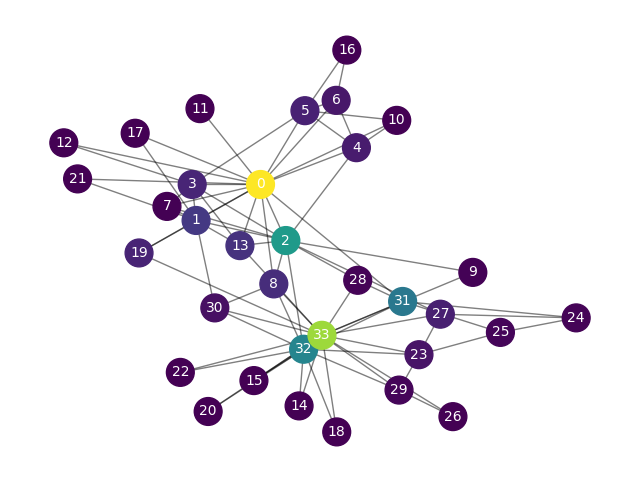

In [7]:
G = nx.karate_club_graph()
G.add_edges_from([(1,2),(2,3),(2,4),(3,5),(4,5)])

bc_ind = indicator_betweenness_unscaled(G, endpoints=False)
print(bc_ind)
node_values = [bc_ind[v] for v in G.nodes()]

# Draw
pos = nx.spring_layout(G, seed=42)  # layout for positioning

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(
    G, pos,
    node_color=node_values,
    cmap=plt.cm.viridis,   # choose any matplotlib colormap
    node_size=400
)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="white")
plt.axis("off")
plt.show()

### P3 (b)

In [8]:
class CentralityError(Exception):
    """Custom exception for centrality computation errors."""

def _validate_graph(G, require_connected=False, messages=None):
    if messages is None:
        messages = []

    # ii) Not a networkx object
    if not isinstance(G, (nx.Graph, nx.DiGraph, nx.MultiGraph, nx.MultiDiGraph)):
        raise TypeError(
            "Expected a NetworkX graph (Graph/DiGraph/MultiGraph/MultiDiGraph), "
            f"got {type(G).__name__!r}."
        )

    n = G.number_of_nodes()
    m = G.number_of_edges()

    if n == 0:
        # iii) No connectivity / empty
        raise CentralityError("Empty graph: no nodes; betweenness centrality is undefined.")

    if n == 1:
        messages.append("Single-node graph: betweenness for the only node is 0 by definition.")

    if m == 0 and n > 1:
        # iii) No connectivity / edgeless
        messages.append(
            "Edgeless graph: no paths exist between distinct nodes; all betweenness scores are 0."
        )

    # Optional strict connectivity requirement
    if require_connected:
        if G.is_directed():
            if not nx.is_weakly_connected(G):
                raise CentralityError(
                    "Graph is not weakly connected: some node pairs are unreachable; "
                    "betweenness across those pairs is undefined under this setting."
                )
        else:
            if not nx.is_connected(G):
                raise CentralityError(
                    "Graph is not connected: some node pairs are unreachable; "
                    "betweenness across those pairs is undefined under this setting."
                )
    else:
        # Soft warning for common “not enough connectivity” cases
        if G.is_directed():
            if not nx.is_weakly_connected(G) and m > 0:
                messages.append(
                    "Warning: directed graph is not weakly connected; unreachable pairs will be ignored "
                    "(their contribution is 0) which can bias centrality toward nodes in larger/denser components."
                )
        else:
            if not nx.is_connected(G) and m > 0:
                messages.append(
                    "Warning: undirected graph is not connected; unreachable pairs will be ignored "
                    "(their contribution is 0) which can bias centrality toward nodes in larger/denser components."
                )

    return messages


def all_shortest_from(G, s):
    """
    Unweighted BFS from source s.
    Returns:
      dist[v] : shortest-path distance from s to v (=-1 if unreachable)
      g[v]    : number of shortest paths from s to v
      P[v]    : list of predecessors of v on shortest s->v paths
    """
    # iii-b) Node not present
    if s not in G:
        raise KeyError(f"Source node {s!r} is not in the graph.")

    dist = {v: -1 for v in G.nodes()}
    g    = {v:  0 for v in G.nodes()}
    P    = {v: [] for v in G.nodes()}

    dist[s] = 0
    g[s] = 1

    Q = deque([s])
    while Q:
        v = Q.popleft()
        # Use G.successors for DiGraph to respect direction; neighbors() works for undirected.
        nbr_iter = G.successors(v) if isinstance(G, (nx.DiGraph, nx.MultiDiGraph)) else G.neighbors(v)
        for w in nbr_iter:
            if dist[w] < 0:
                dist[w] = dist[v] + 1
                Q.append(w)
            if dist[w] == dist[v] + 1:
                g[w] += g[v]
                P[w].append(v)
    return dist, g, P


def indicator_betweenness_unscaled(
    G,
    endpoints=False,
    *,
    return_messages=False,
    require_connected=False
):
    """
    Indicator betweenness (UNWEIGHTED, UNSCALED):
      For each ordered pair (s, t), s!=t, every node i on at least one
      shortest s->t path gets + 1 / g_st (once per pair).

    endpoints=False: do NOT credit s or t.
    endpoints=True : DO credit s and t as well.

    Parameters
    ----------
    G : networkx graph
    endpoints : bool
    return_messages : bool
        If True, returns (bc_dict, messages_list). Otherwise returns bc_dict only.
    require_connected : bool
        If True, raises on disconnected graphs (see _validate_graph).
    """
    messages = _validate_graph(G, require_connected=require_connected, messages=[])

    # iii) Trivial cases handled up-front to avoid unnecessary work
    n = G.number_of_nodes()
    m = G.number_of_edges()
    if n == 1:
        only = next(iter(G.nodes()))
        result = {only: 0.0}
        return (result, messages) if return_messages else result
    if m == 0:
        result = {v: 0.0 for v in G.nodes()}
        return (result, messages) if return_messages else result

    bc = {v: 0.0 for v in G.nodes()}
    nodes = list(G.nodes())

    # iv) Numerical safety: everything below ensures we never divide by zero.
    #     We also check for path count overflow, though in Python ints are unbounded.
    skipped_zero_path_pairs = 0

    for s in nodes:
        # all_shortest_from already checks "node not in graph"
        dist, g, P = all_shortest_from(G, s)

        # Reachable targets t != s with at least one shortest path
        targets = [t for t in nodes if t != s and g[t] > 0]

        # Count unreachable targets for diagnostics
        skipped_zero_path_pairs += sum(1 for t in nodes if t != s and g[t] == 0)

        for t in targets:
            # iv) Guard divide-by-zero (shouldn’t trigger due to filter, but keep it bulletproof)
            paths_st = g[t]
            if paths_st == 0:
                continue  # unreachable; contributes nothing

            contrib = 1.0 / paths_st

            # Reverse-walk the predecessor DAG from t to mark all nodes on
            # at least one shortest s->t path.
            stack = [t]
            visited = {t}
            while stack:
                w = stack.pop()

                # Credit rule: indicator version
                if endpoints:
                    bc[w] += contrib
                else:
                    if w != s and w != t:
                        bc[w] += contrib

                for v in P[w]:
                    if v not in visited:
                        visited.add(v)
                        stack.append(v)

    if skipped_zero_path_pairs > 0:
        messages.append(
            f"Info: {skipped_zero_path_pairs} ordered (s,t) pairs were unreachable; "
            "they contribute 0 by definition."
        )

    return (bc, messages) if return_messages else bc


In [10]:
# 1) Sanity check with a tiny connected graph
import networkx as nx
G = nx.path_graph(4)  # 0-1-2-3

bc, msgs = indicator_betweenness_unscaled(G, return_messages=True)
print("BC:", bc)
print("Messages:", msgs)

# 2) Edgeless graph -> zeros + message
H = nx.empty_graph(3)
bc2, msgs2 = indicator_betweenness_unscaled(H, return_messages=True)
print("BC (edgeless):", bc2)
print("Messages (edgeless):", msgs2)

# 3) Disconnected graph -> works, plus warning message
I = nx.Graph()
I.add_edges_from([(1,2), (3,4)])  # 2 components
bc3, msgs3 = indicator_betweenness_unscaled(I, return_messages=True)
print("BC (disconnected):", bc3)
print("Messages (disconnected):", msgs3)


BC: {0: 0.0, 1: 4.0, 2: 4.0, 3: 0.0}
Messages: []
BC (edgeless): {0: 0.0, 1: 0.0, 2: 0.0}
Messages (edgeless): ['Edgeless graph: no paths exist between distinct nodes; all betweenness scores are 0.']
BC (disconnected): {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
Messages (disconnected): ['Warning: undirected graph is not connected; unreachable pairs will be ignored (their contribution is 0) which can bias centrality toward nodes in larger/denser components.', 'Info: 8 ordered (s,t) pairs were unreachable; they contribute 0 by definition.']


### P3 (c)


In [12]:
import networkx as nx

def nx_bc(G, endpoints=False):
    # Use normalized=False to match "unscaled" convention
    return nx.betweenness_centrality(G, normalized=False, endpoints=endpoints)

def diff(bc1, bc2, tol=1e-12):
    keys = sorted(set(bc1) | set(bc2))
    return {k: bc1.get(k, 0.0) - bc2.get(k, 0.0) for k in keys if abs(bc1.get(k,0.0)-bc2.get(k,0.0)) > tol}

# 1) Unique-shortest-path graphs -> MATCH
# (a) Path graph (tree)
G1 = nx.path_graph(5)  # 0-1-2-3-4
my1  = indicator_betweenness_unscaled(G1, endpoints=False)
nx1  = nx_bc(G1, endpoints=False)
print("Path graph diffs:", diff(my1, nx1))  # expect {}

# (b) Directed acyclic with unique paths
G2 = nx.DiGraph()
G2.add_edges_from([(0,1),(1,2),(2,3),(1,3)])
my2  = indicator_betweenness_unscaled(G2, endpoints=False)
nx2  = nx_bc(G2, endpoints=False)
print("DAG diffs:", diff(my2, nx2))  # expect {}

# 2) Multiple *disjoint* shortest paths where a node lies on only one of them -> STILL MATCH
#    Cycle C4: opposite corners have two shortest paths, each middle node on exactly one.
G3 = nx.cycle_graph(4)  # 0-1-2-3-0
my3  = indicator_betweenness_unscaled(G3, endpoints=False)
nx3  = nx_bc(G3, endpoints=False)
print("C4 diffs:", diff(my3, nx3))  # expect {}

# 3) Multiple shortest paths that BOTH pass through the SAME node -> DIFFER
#    "Diamond-with-merging" shape: s--x--v--t and s--y--v--t are both shortest; both include v.
#    Undirected version:
G4 = nx.Graph()
s, x, y, v, t = 0, 1, 2, 3, 4
G4.add_edges_from([(s,x),(s,y),(x,v),(y,v),(v,t)])
my4  = indicator_betweenness_unscaled(G4, endpoints=False)
nx4  = nx_bc(G4, endpoints=False)
print("Diamond diffs:", diff(my4, nx4))  # expect nonempty, v will be lower in metric

# 4) Disconnected graph -> both effectively ignore unreachable pairs, results often 0s
G5 = nx.Graph()
G5.add_edges_from([(1,2), (3,4)])  # two components
my5, msg5 = indicator_betweenness_unscaled(G5, endpoints=False, return_messages=True)
nx5 = nx_bc(G5, endpoints=False)
print("Disconnected diffs:", diff(my5, nx5))  # usually {}
print("Messages:", msg5)


Path graph diffs: {1: 3.0, 2: 4.0, 3: 3.0}
DAG diffs: {}
C4 diffs: {0: 0.5, 1: 0.5, 2: 0.5, 3: 0.5}
Diamond diffs: {0: 0.5, 1: 1.0, 2: 1.0, 3: 2.5}
Disconnected diffs: {}
Messages: ['Warning: undirected graph is not connected; unreachable pairs will be ignored (their contribution is 0) which can bias centrality toward nodes in larger/denser components.', 'Info: 8 ordered (s,t) pairs were unreachable; they contribute 0 by definition.']


### Problem 4a

In [2]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

In [8]:
catalog_res = requests.get('https://catalog.northeastern.edu/course-descriptions/phth/')
catalog_html = catalog_res.text

soup = BeautifulSoup(catalog_html)

In [9]:
COURSE_CODE_RE = re.compile(r'\b[A-Z&]{2,}\s?\d{4}\b')

def norm(s: str | None) -> str | None:
    """Normalize whitespace and non-breaking spaces."""
    if s is None:
        return None
    return " ".join(s.replace("\xa0", " ").split())

def extract_prereq_codes(prereq_p):
    """
    Given the <p> tag that contains prerequisites, return a list of course codes.
    Works for both <a> links and plain text course codes.
    """
    if prereq_p is None:
        return []

    found = []
    seen = set()

    # 1) linked prereqs
    for a in prereq_p.find_all('a'):
        code = norm(a.get_text(strip=True))
        if code and COURSE_CODE_RE.fullmatch(code) and code not in seen:
            seen.add(code)
            found.append(code)

    # 2) unlinked prereqs from the raw text
    text = norm(prereq_p.get_text(" "))
    if text:
        for code in COURSE_CODE_RE.findall(text):
            code = norm(code)
            if code not in seen:
                seen.add(code)
                found.append(code)

    return found

def parse_courses(soup):
    """
    Parse all course blocks from the HTML soup and return a list of dicts.
    Each dict includes: course_crn, course_title, credits, description, prerequisites (list of strings).
    """
    course_info = []

    for class_i in soup.find_all('div', {'class': 'courseblock'}):
        # course header
        title_p = class_i.find('p', {'class': 'courseblocktitle noindent'})
        if not title_p:
            continue
        class_title_total_i = norm(title_p.get_text())
        try:
            crn_i, title_i, credit_i = class_title_total_i.split('. ', 2)
        except ValueError:
            # sometimes format may differ
            continue
        # credits
        credit_i = credit_i.strip()
        credit_i = re.sub(r"[()]", '', credit_i)
        
        # description
        desc_p = class_i.find('p', class_='cb_desc')
        desc_i = norm(desc_p.get_text()) if desc_p else None

        # find prereq <p>
        prereq_p = None
        for p in class_i.find_all('p', class_='courseblockextra noindent'):
            strong = p.find('strong')
            head = norm(strong.get_text()) if strong else ''
            if head and head.lower().startswith('prerequisite'):
                prereq_p = p
                break

        prereqs = extract_prereq_codes(prereq_p)

        course_info.append({
            "course_crn": crn_i,
            "course_title": title_i,
            "credits": credit_i,
            "description": desc_i,
            "prerequisite": prereqs
        })

    return pd.DataFrame(course_info)


In [10]:
catalog_html = catalog_res.text
soup = BeautifulSoup(catalog_html)

courses = parse_courses(soup)
print(courses[["course_crn", "credits", "prerequisite"]])  

   course_crn  credits prerequisite
0   PHTH 1260  4 Hours           []
1   PHTH 1261  4 Hours           []
2   PHTH 1270  4 Hours           []
3   PHTH 2210  4 Hours           []
4   PHTH 2300  4 Hours           []
..        ...      ...          ...
67  PHTH 8986  0 Hours           []
68  PHTH 9000  0 Hours           []
69  PHTH 9990  0 Hours  [PHTH 9000]
70  PHTH 9991  0 Hours  [PHTH 9990]
71  PHTH 9996  0 Hours  [PHTH 9991]

[72 rows x 3 columns]


### Problem 4b

In [11]:
from pyvis.network import Network
G = nx.DiGraph()

In [12]:
def curriculum_graph(df):
    for row in courses.itertuples():
        G.add_node(
            row.course_crn,
            title = row.course_title,
            credits = row.credits,
            desc = row.description
        )
    
    for row in courses.itertuples():
        for prereq in row.prerequisite:
            if prereq not in G:
                G.add_node(prereq)
            G.add_edge(prereq, row.course_crn)
    
    return G

def draw_curriculum_graph_pyvis(G, output="curriculum_graph.html"):
    net = Network(height="750px", width="100%", directed=True, notebook=False)

    for n, d in G.nodes(data=True):
        net.add_node(n, label=n, title=d.get("title",""), color="lightblue", size=12)
    for u, v in G.edges():
        net.add_edge(u, v, color="gray", arrowStrikethrough=False)

    # simple physics
    net.force_atlas_2based()

    # Avoid the notebook templating path entirely:
    net.write_html(output)   # <- use this instead of net.show()
    print(f"Graph saved to {output}")


In [13]:
G = curriculum_graph(courses)

draw_curriculum_graph_pyvis(G, "curriculum_graph.html")

Graph saved to curriculum_graph.html


### Problem 4c

In [14]:
from urllib.parse import urljoin
departments_req = requests.get('https://catalog.northeastern.edu/course-descriptions/')
departments_html = catalog_res.text
dept_soup = BeautifulSoup(departments_html)

In [15]:
BASE = "https://catalog.northeastern.edu"
departments = []
def get_dept(dept_soup):
    uls = dept_soup.find_all('ul', {'class': 'nav levelone'})
    for li in uls[0].find_all('li'):
        a = li.find('a', href=True)
        dept_href = a['href']
        dept_raw = a.get_text().strip()
        dept_name = dept_raw.split('(')[0].replace(' -\u200b', '').strip()
        dept_abbr = dept_href.strip('/').split('/')[-1].upper()
    
        
        dept_url = urljoin(BASE, dept_href)
        departments.append({
            'dept_name': dept_name,
            'dept_abbr': dept_abbr,
            'dept_url': dept_url
        })
    return pd.DataFrame(departments)

In [16]:
dept_df = get_dept(dept_soup)

print(dept_df)

                                  dept_name dept_abbr  \
0                                Accounting      ACCT   
1                            Accounting CPS       ACC   
2        Advanced Manufacturing Systems CPS       AVM   
3                           African Studies      AFRS   
4                          Africana Studies      AFCS   
..                                      ...       ...   
226            Technical Communications CPS       TCC   
227               Telecommunication Systems      TELE   
228                   Technology Leadership      TELR   
229                                 Theatre      THTR   
230  Women’s, Gender, and Sexuality Studies      WMNS   

                                              dept_url  
0    https://catalog.northeastern.edu/course-descri...  
1    https://catalog.northeastern.edu/course-descri...  
2    https://catalog.northeastern.edu/course-descri...  
3    https://catalog.northeastern.edu/course-descri...  
4    https://catalog.northeast

In [17]:
all_dept = []
def get_all_courses(dept_df):
    for i, row in dept_df.iterrows():
        name = row['dept_name']
        abbr = row['dept_abbr']
        url = row['dept_url']
    
        try:
            dept_req_i = requests.get(url)
            dept_html_i = dept_req_i.text
            dept_soup_i = BeautifulSoup(dept_html_i)
            df = parse_courses(dept_soup_i)
            df.insert(0, 'subject', abbr)
            df.insert(1, 'department name', name)

            all_dept.append(df)
            
        except Exception as e:
                print(f"!! Failed on {abbr} ({url}): {e}")
    
    courses = pd.concat(all_dept).drop_duplicates(subset=['course_crn', 'course_title'])
    return courses

In [18]:
courses_df = get_all_courses(dept_df)
courses_df.head()

# save courses
courses_df.to_parquet('neu_courses.parquet', index=False)

(c) Which department has the most prerequisites per course, on average?

In [19]:
courses_df = pd.read_parquet('neu_courses.parquet')
df = courses_df.copy()
df["prereq_count"] = df["prerequisite"].apply(len)

dept_avg = (
    df.groupby(['department name']).agg(
        n_courses = ('course_crn', 'nunique'),
        avg_prereq = ('prereq_count', 'mean')
    )
    .sort_values('avg_prereq', ascending=False)
)
dept_avg["avg_prereq"] = dept_avg["avg_prereq"].round(3) 

# print(dept_avg.head(5))
print(df.head())


  subject department name course_crn  \
0    ACCT      Accounting  ACCT 1201   
1    ACCT      Accounting  ACCT 1209   
2    ACCT      Accounting  ACCT 1990   
3    ACCT      Accounting  ACCT 2301   
4    ACCT      Accounting  ACCT 2990   

                                course_title    credits  \
0         Financial Accounting and Reporting    4 Hours   
1         Financial Accounting and Reporting    4 Hours   
2                                   Elective  1-4 Hours   
3  Profit Analysis for Managers and Advisors    4 Hours   
4                                   Elective  1-4 Hours   

                                         description  \
0  Covers the basic concepts underlying financial...   
1  Does not count as credit for business majors. ...   
2  Offers elective credit for courses taken at ot...   
3  Focuses on the development and analysis of inf...   
4  Offers elective credit for courses taken at ot...   

                        prerequisite  prereq_count  
0             

In [53]:
from networkx.algorithms.dag import dag_longest_path

def build_course_graph(course_df):
    G = nx.DiGraph()
    for _, row in courses_df.iterrows():
        course = row['course_crn']
        G.add_node(course, 
                   title = row['course_title']
                  )
        for prereq in row['prerequisite']:
            if prereq:
                G.add_node(prereq)
                G.add_edge(prereq, course)

    return G

In [55]:
G = build_course_graph(courses_df)

# Check if it’s a DAG
if nx.is_directed_acyclic_graph(G):
    longest_path = dag_longest_path(G)
else:
    # --- Show a few cycles to help debug the catalog anomalies
    print("Cycles found. Showing up to 5 example cycles:")
    for i, cyc in enumerate(nx.simple_cycles(G)):
        print("  " + " → ".join(cyc + [cyc[0]]))
        if i >= 4:
            break

    # --- Collapse SCCs to a DAG and take the longest path there
    C = nx.condensation(G)  # nodes are components (SCCs), edges preserve reachability
    comp_path = dag_longest_path(C)  # list of component IDs

    # pick a representative course code for each component for display
    def rep_component_node(comp_node):
        members = C.nodes[comp_node]["members"]  # set/list of original nodes in this SCC
        return sorted(members)[0]  # deterministic representative

    path_courses = [rep_component_node(c) for c in comp_path]

longest_len = max(0, len(path_courses) - 1)
print(f"\nLongest chain length (edges): {longest_len}")
print("Chain (start → … → end):")
for c in path_courses:
    t = G.nodes[c].get("title")
    print(f"  {c}" + (f" — {t}" if t else ""))

⚠️ Cycles found. Showing up to 5 example cycles:
  SPNS 2101 → SPNS 2101
  SPNS 2102 → SPNS 2102
  SPNS 3101 → SPNS 3101
  SPNS 3102 → SPNS 3102
  SPNS 1101 → SPNS 1101

Longest chain length (edges): 9
Chain (start → … → end):
  BIOL 1107 — Foundations of Biology
  BIOL 1113 — General Biology 2
  PHSC 2301 — Human Physiology 1
  PHSC 2303 — Human Physiology 2
  HSCI 1105 — Human Nutrition
  NRSG 2220 — Health Assessment and Fundamental Nursing Skills
  NRSG 3320 — Nursing Care of Adults 1
  NRSG 3420 — Nursing Care of Adults 2
  NRSG 4502 — Nursing Care of the Child
  NRSG 4995 — Comprehensive Nursing Practicum


### Problem 5

In [23]:
path = '/Users/lpwer/Documents/NetSIPhD/PHYS7332_NetData/HW1/rt_bahrain/rt_bahrain.edges'
df = pd.read_csv(
    path,
    sep=",",                  # whitespace-separated
    header=None,                 # no header row in file
    names=["retweeter", "original_author", "timestamp"],  # assign names
    engine="python"
)
G_citation = nx.from_pandas_edgelist(df, 'retweeter', 'original_author', 'timestamp', create_using=nx.DiGraph())

print(G_citation.number_of_nodes(), 'nodes', G_citation.number_of_edges(), 'edges')
print(df)

4676 nodes 8007 edges
      retweeter  original_author   timestamp
0          4165              533  1348022857
1          4165             1016  1348026203
2          2445              550  1347990443
3          2445             4177  1347990219
4          2445              201  1347989927
...         ...              ...         ...
8002        298             1140  1347997801
8003       3964             1890  1348017528
8004       3964             3802  1348017551
8005       1549             2595  1348021567
8006       1616             2121  1348059465

[8007 rows x 3 columns]


### P5(a)
nodes: tweeter users
edges: Retweets
This datasets is collected from the "bahrain" hashtag. This is a retweet network. 
https://networkrepository.com/rt-bahrain.php

In [38]:
# For now, remove all isolated nodes from the citation networks. Only keep the connected component
def directed_1in1out_core(H):
    Gc = H.copy()
    # Iteratively prune nodes with in==0 or out==0 (like a directed 1-in/1-out core)
    changed = True
    while changed:
        changed = False
        to_drop = [n for n in Gc if Gc.in_degree(n) == 0 or Gc.out_degree(n) == 0]
        if to_drop:
            Gc.remove_nodes_from(to_drop)
            changed = True
    return Gc

# Build swappable core (keep a mapping to reattach outside degrees later if desired)
G_core = directed_1in1out_core(G_citation)
# print("Original:", G_citation.number_of_nodes(), "nodes,", G_citation.number_of_edges(), "edges")
# print("Core:    ", G_core.number_of_nodes(), "nodes,", G_core.number_of_edges(), "edges")

# If the core is small, directed swaps will still be hard; scale nswap to the actual core size
Ecore = G_core.number_of_edges()

# Try swaps with conservative targets and generous attempts
nswap_target = 3 * Ecore
max_tries    = 20 * Ecore   

G_rand_core = G_core.copy()
nx.directed_edge_swap(G_rand_core, nswap=nswap_target, max_tries=max_tries, seed=42)

# stitch the core back together with untouched exterior nodes:
G_randomized = G_citation.copy()
G_randomized.remove_nodes_from(G_core.nodes)
G_randomized = nx.compose(G_randomized, G_rand_core)  # put randomized core back in


In [55]:
# Clustering coefficient distribution
# Directed local clustering (Fagiolo, used by NetworkX for DiGraph)
c_dir_emp  = nx.clustering(G_citation)       
c_dir_rand = nx.clustering(G_randomized)

# Averages & transitivity (global)
avg_dir_emp   = nx.average_clustering(G_citation)
avg_dir_rand  = nx.average_clustering(G_randomized)
trans_emp     = nx.transitivity(G_citation)       # triangle density (global)
trans_rand    = nx.transitivity(G_randomized)

print(f"Directed average clustering (empirical):  {avg_dir_emp:.4f}")
print(f"Directed average clustering (randomized): {avg_dir_rand:.4f}")
print(f"Transitivity (empirical):                 {trans_emp:.4f}")
print(f"Transitivity (randomized):                {trans_rand:.4f}")
print(avg_dir_emp)

Directed average clustering (empirical):  0.0090
Directed average clustering (randomized): 0.0032
Transitivity (empirical):                 0.0018
Transitivity (randomized):                0.0008
0.009023453173790295


[8.82066400e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.21074849e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.41593064e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.59476148e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.78167774e-02
 0.00000000e+00 3.03760691e-02 0.00000000e+00 2.38220247e-02
 0.00000000e+00 1.93619341e-02 0.00000000e+00 1.33112439e-02
 5.47596550e-03 0.00000000e+00 2.22191237e-03 2.36781951e-03
 3.31184174e-03 1.02938549e-03 9.59859711e-04 6.71272333e-04
 4.17289263e-04 1.94552554e-04 0.00000000e+00 3.38318988e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.11192298e-04]
[3.36679192e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.70113728e-01 0.00000000e+00
 0.00000000e+00 3.31541903e-01 0.00000000e+00 0.00000000e+00
 1.44088541e-01 0.00000000e+00 6.44480599e-02 0.00000

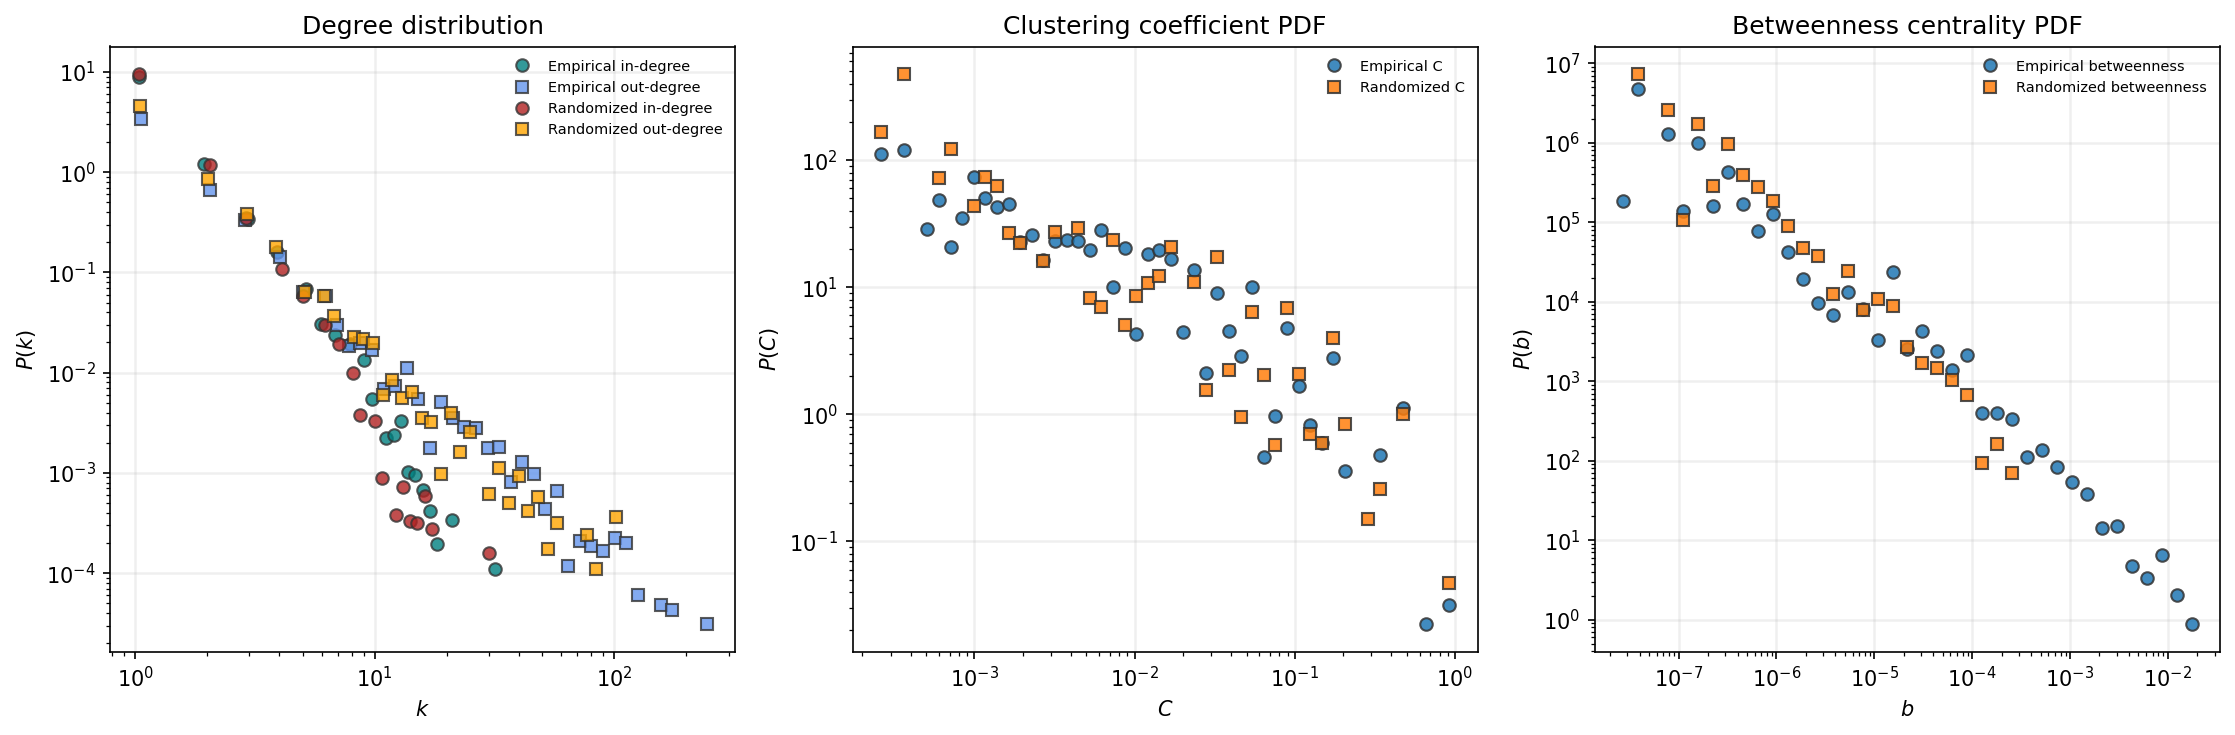

In [66]:
from scipy.stats import spearmanr

# ---------------- Helper for log-binned PDFs ----------------
def log_binned_pdf(x, nbins=50, xmin=None, xmax=None):
    """
    Compute a log-binned probability density for positive data x.
    Returns (x_centers, y_density) suitable for log-log plotting.
    """
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x) & (x > 0)]
    if x.size == 0:
        return np.array([]), np.array([])
    if xmin is None: xmin = x.min()
    if xmax is None: xmax = x.max()
    if xmin == xmax:
        return np.array([xmin]), np.array([1.0])
    edges = np.geomspace(xmin, xmax, nbins + 1)
    counts, edges = np.histogram(x, bins=edges)
    widths  = np.diff(edges)
    centers = np.sqrt(edges[:-1] * edges[1:])  # geometric mean
    pdf = counts / (counts.sum() * widths)
    m = pdf > 0
    return centers[m], pdf[m]

# ---------------- Degree distributions ----------------
nbins = 50
x_in_emp,  y_in_emp  = degree_distribution(G_citation,   number_of_bins=nbins, log_binning=True, directed='in')
x_out_emp, y_out_emp = degree_distribution(G_citation,   number_of_bins=nbins, log_binning=True, directed='out')
x_in_rand, y_in_rand = degree_distribution(G_randomized, number_of_bins=nbins, log_binning=True, directed='in')
x_out_rand,y_out_rand= degree_distribution(G_randomized, number_of_bins=nbins, log_binning=True, directed='out')

# ---------------- Clustering coefficient PDFs ----------------
clust_emp_dict  = nx.clustering(G_citation)      # directed Fagiolo definition
clust_rand_dict = nx.clustering(G_randomized)
clust_emp  = np.fromiter(clust_emp_dict.values(),  dtype=float)
clust_rand = np.fromiter(clust_rand_dict.values(), dtype=float)
c_emp_pos  = clust_emp[clust_emp > 0]
c_rand_pos = clust_rand[clust_rand > 0]
c_xmin = min(c_emp_pos.min(), c_rand_pos.min()) if (c_emp_pos.size and c_rand_pos.size) else None
x_c_emp,  y_c_emp  = log_binned_pdf(c_emp_pos,  nbins=nbins, xmin=c_xmin, xmax=1.0)
x_c_rand, y_c_rand = log_binned_pdf(c_rand_pos, nbins=nbins, xmin=c_xmin, xmax=1.0)

# ---------------- Betweenness centrality PDFs ----------------
bc_emp_dict  = nx.betweenness_centrality(G_citation,   normalized=True, endpoints=False)
bc_rand_dict = nx.betweenness_centrality(G_randomized, normalized=True, endpoints=False)
bc_emp  = np.fromiter(bc_emp_dict.values(),  dtype=float)
bc_rand = np.fromiter(bc_rand_dict.values(), dtype=float)
bc_emp_pos  = bc_emp[bc_emp > 0]
bc_rand_pos = bc_rand[bc_rand > 0]
b_xmin = min(bc_emp_pos.min(), bc_rand_pos.min()) if (bc_emp_pos.size and bc_rand_pos.size) else None
x_b_emp,  y_b_emp  = log_binned_pdf(bc_emp_pos,  nbins=nbins, xmin=b_xmin, xmax=1.0)
x_b_rand, y_b_rand = log_binned_pdf(bc_rand_pos, nbins=nbins, xmin=b_xmin, xmax=1.0)

# ---------------- Plot all three ----------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)

# Panel 1: Degree distributions
ax = axes[0]
ax.loglog(x_in_emp,  y_in_emp,  'o', color='teal',           alpha=0.8, mec='.2', label='Empirical in-degree')
ax.loglog(x_out_emp, y_out_emp, 's', color='cornflowerblue', alpha=0.8, mec='.2', label='Empirical out-degree')
ax.loglog(x_in_rand, y_in_rand, 'o', color='firebrick',      alpha=0.8, mec='.2', label='Randomized in-degree')
ax.loglog(x_out_rand,y_out_rand,'s', color='orange',         alpha=0.8, mec='.2', label='Randomized out-degree')
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$P(k)$")
ax.set_title("Degree distribution")
ax.legend(fontsize='x-small', frameon=False)
ax.grid(linewidth=1.2, alpha=0.2)

# Panel 2: Clustering coefficient PDFs
ax = axes[1]
if x_c_emp.size:  ax.loglog(x_c_emp,  y_c_emp,  'o', alpha=0.85, mec='.2', label='Empirical C')
if x_c_rand.size: ax.loglog(x_c_rand, y_c_rand, 's', alpha=0.85, mec='.2', label='Randomized C')
ax.set_xlabel(r"$C$")
ax.set_ylabel(r"$P(C)$")
ax.set_title("Clustering coefficient PDF")
ax.legend(fontsize='x-small', frameon=False)
ax.grid(linewidth=1.2, alpha=0.2)

# Panel 3: Betweenness centrality PDFs
ax = axes[2]
if x_b_emp.size:  ax.loglog(x_b_emp,  y_b_emp,  'o', alpha=0.85, mec='.2', label='Empirical betweenness')
if x_b_rand.size: ax.loglog(x_b_rand, y_b_rand, 's', alpha=0.85, mec='.2', label='Randomized betweenness')
ax.set_xlabel(r"$b$")
ax.set_ylabel(r"$P(b)$")
ax.set_title("Betweenness centrality PDF")
ax.legend(fontsize='x-small', frameon=False)
ax.grid(linewidth=1.2, alpha=0.2)

plt.tight_layout()
plt.show()


[8.82066400e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.21074849e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.41593064e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.59476148e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.78167774e-02
 0.00000000e+00 3.03760691e-02 0.00000000e+00 2.38220247e-02
 0.00000000e+00 1.93619341e-02 0.00000000e+00 1.33112439e-02
 5.47596550e-03 0.00000000e+00 2.22191237e-03 2.36781951e-03
 3.31184174e-03 1.02938549e-03 9.59859711e-04 6.71272333e-04
 4.17289263e-04 1.94552554e-04 0.00000000e+00 3.38318988e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.11192298e-04]
[3.36679192e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.70113728e-01 0.00000000e+00
 0.00000000e+00 3.31541903e-01 0.00000000e+00 0.00000000e+00
 1.44088541e-01 0.00000000e+00 6.44480599e-02 0.00000

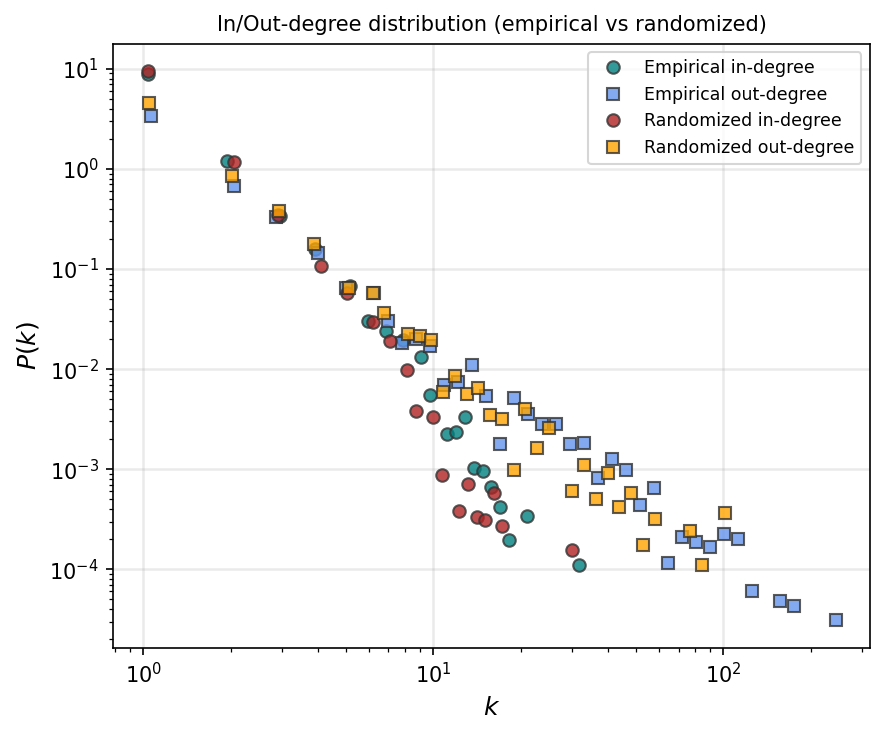

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=150)

# ------------------- Degree distribution plot section -------------------
nbins = 50
# --- Empirical
x_in_emp,  y_in_emp  = degree_distribution(G_citation, number_of_bins=nbins, log_binning=True, directed='in')
x_out_emp, y_out_emp = degree_distribution(G_citation, number_of_bins=nbins, log_binning=True, directed='out')

# --- Randomized
x_in_rand,  y_in_rand  = degree_distribution(G_randomized, number_of_bins=nbins, log_binning=True, directed='in')
x_out_rand, y_out_rand = degree_distribution(G_randomized, number_of_bins=nbins, log_binning=True, directed='out')

# --- Plot
ax.loglog(x_in_emp,  y_in_emp,  'o', color='teal',           alpha=0.8, mec='.2', label='Empirical in-degree')
ax.loglog(x_out_emp, y_out_emp, 's', color='cornflowerblue', alpha=0.8, mec='.2', label='Empirical out-degree')
ax.loglog(x_in_rand, y_in_rand, 'o', color='firebrick',      alpha=0.8, mec='.2', label='Randomized in-degree')
ax.loglog(x_out_rand,y_out_rand,'s', color='orange',         alpha=0.8, mec='.2', label='Randomized out-degree')

ax.set_xlabel(r"$k$", fontsize='large')
ax.set_ylabel(r"$P(k)$", fontsize='large')
ax.set_title('In/Out-degree distribution (empirical vs randomized)', fontsize='medium')
ax.legend(fontsize='small')
ax.grid(linewidth=1.2, color='#999999', alpha=0.2, linestyle='-')
plt.tight_layout()
plt.show()